In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
import keras
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling2D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from glob import glob
import cv2
from sklearn.utils import shuffle


In [6]:
# READ IN AUDIO FILES 
audio = "/content/drive/My Drive/SIH/dataset/audio_speech_actors_01-24/"

In [7]:
dicts={'01' : 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disgust', '08' : 'surprised'}

In [8]:
path_main=audio

In [11]:
folders_main = os.listdir(path_main)

# Transfer Learning

## Attach labels to Stretch

In [12]:
import glob
angry = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/angry/*.*')
calm = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/calm/*.*')
disgust = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/disgust/*.*')
fearful = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/fearful/*.*')
happy = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/happy/*.*')
neutral = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/neutral/*.*')
sad = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/sad/*.*')
surprised = glob.glob('/content/drive/My Drive/SIH/dataset/stretch/surprised/*.*')

In [13]:
data = []
labels = []

for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Angry')
for i in calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Calm')
for i in disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Disgust')
for i in fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Fearful')
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Happy')
for i in neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Neutral')
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Sad')
for i in surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Surprised')

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3,random_state=22, stratify=labels)

In [14]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for labels in os.listdir(directory): 
        if labels == 'angry': 
            label = 'angry'
        elif labels == 'calm':
            label = 'calm'
        elif labels == 'disgust':
            label = 'disgust'
        elif labels == 'fearful':
            label = 'fearful'
        elif labels == 'happy':
            label = 'happy'
        elif labels == 'neutral':
            label = 'neutral'
        elif labels == 'sad':
            label = 'sad'
        elif labels == 'surprised':
            label = 'surprised'
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(75,75)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            # image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=200) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {'angry':'angry', 'calm':'calm', 'disgust':'disgust', 'fearful':'fearful', 'happy':'happy', 'neutral':'neutral','sad':'sad','surprised':'surprised'}
    
    return labels[class_code]

In [16]:
Images, Labels = get_images('/content/drive/My Drive/SIH/dataset/stretch/') #Extract the training images from the folders.


# Process Images for Transfer Learning

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Images, Labels, test_size=0.3,random_state=22, stratify=Labels)

# X_model, X_test, y_model, y_test = train_test_split(Images, Labels, test_size=0.3,random_state=22, stratify=Labels)
# X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.3,random_state=22,stratify=y_model)


In [21]:
lb = LabelEncoder()

X_train=np.array(X_train)/255
X_test=np.array(X_test)/255
# X_val=np.array(X_val)/255

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# y_val=np_utils.to_categorical(lb.fit_transform(y_val))
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [22]:
X_test.shape

(270, 75, 75, 3)

In [23]:
X_train.shape

(630, 75, 75, 3)

In [24]:
print(y_test)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]]


In [25]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


# New VGG16

In [33]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(75, 75, 3))
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(8, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [34]:
for layer in transfer_model.layers[:19]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_1 True
20 dense_3 True
21 dropout_1 True
22 dense_4 True
23 dense_5 True


In [35]:
from tensorflow.keras import layers, models, Model, optimizers

learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

In [36]:
# Here we use testing set as validation set
history = transfer_model.fit(X_train, y_train, batch_size = 16, epochs=100, validation_data=(X_test,y_test))

Epoch 1/100
40/40 [==============================] - 13s 46ms/step - loss: 2.1032 - accuracy: 0.1063 - val_loss: 2.0691 - val_accuracy: 0.1333
Epoch 2/100
40/40 [==============================] - 1s 22ms/step - loss: 2.0883 - accuracy: 0.1175 - val_loss: 2.0722 - val_accuracy: 0.1333
Epoch 3/100
40/40 [==============================] - 1s 22ms/step - loss: 2.0835 - accuracy: 0.1365 - val_loss: 2.0630 - val_accuracy: 0.1333
Epoch 4/100
40/40 [==============================] - 1s 22ms/step - loss: 2.0941 - accuracy: 0.1159 - val_loss: 2.0719 - val_accuracy: 0.1333
Epoch 5/100
40/40 [==============================] - 1s 23ms/step - loss: 2.0871 - accuracy: 0.1206 - val_loss: 2.0665 - val_accuracy: 0.1333
Epoch 6/100
40/40 [==============================] - 1s 23ms/step - loss: 2.0853 - accuracy: 0.1429 - val_loss: 2.0637 - val_accuracy: 0.1333
Epoch 7/100
40/40 [==============================] - 1s 22ms/step - loss: 2.0830 - accuracy: 0.1413 - val_loss: 2.0635 - val_accuracy: 0.1333
Epoch

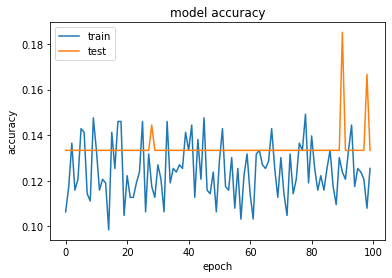

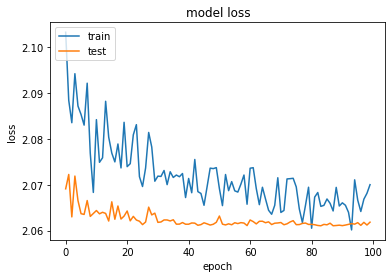

In [37]:
        # PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()